# ATTACHMENT 3: Portfolio Analysis (MTN+BKNG)

## Preliminary Code
First of all, we import relevant libraries and extract the financial data related to both the stocks (i.e., Vail Resorts Inc. and Booking Holdings Inc.) useful for the subsequent analysis.

In [ ]:
# Loading useful libraries
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Extracting historical stocks' prices thorugh Yahoo Finance
vail = yf.download('MTN', start='2010-01-01', end='2024-04-01') # Vail Resorts Inc.
vail.index = pd.to_datetime(vail.index)
vail = vail['Adj Close']

booking = yf.download('BKNG', start='2010-01-01', end='2024-04-01') # Booking Holdings Inc.
booking.index = pd.to_datetime(booking.index)
booking = booking['Adj Close']

# Combining the stocks' data
prices = pd.concat([vail, booking], axis=1)
prices.columns = ['MTN', 'BKNG']

# Analyzing returns
returns = prices.pct_change().dropna()
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

# Extracting the risk-free rate based on the 10-year Treasury Note
treasury = yf.Ticker("^TNX")
risk_free_rate = treasury.history(period="5y")['Close'].iloc[-1] / 100  # Converting basis points to decimal

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Portfolio Optimization
We analyze all the possible portfolios' performances through specifically designed functions.

In [ ]:
# Defining the functions for portfolio performance metrics
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, returns
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_std, p_ret = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_std

# Defining the constraints
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(len(mean_returns)))

# Initial guess (equal distribution)
num_assets = len(mean_returns)
initial_guess = num_assets * [1. / num_assets,]

# Defining the optimization function
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    args = (mean_returns, cov_matrix, risk_free_rate)
    opts = minimize(neg_sharpe_ratio, initial_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return opts

# Applying the functions
optimal_portfolio = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
optimal_weights = optimal_portfolio.x
expected_return, expected_volatility = portfolio_annualized_performance(optimal_weights, mean_returns, cov_matrix)

## Plotting
We plot the efficient frontier and related results.

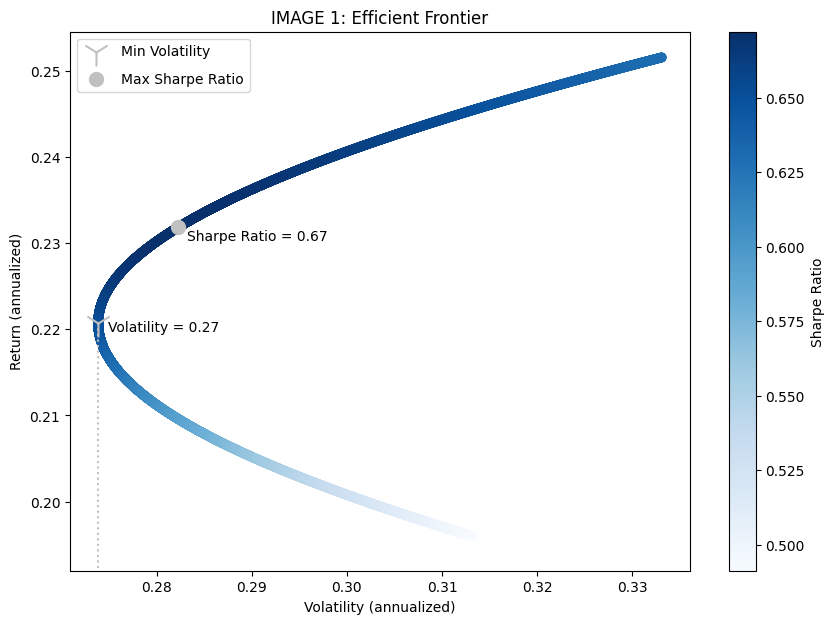


Portfolio with Maximum Sharpe Ratio:
Return         0.231800
Volatility     0.282240
Sharpe         0.672122
Vail_Weight    0.355236
Name: 3552, dtype: float64

Portfolio with Minimum Volatility:
Return         0.220710
Volatility     0.273866
Sharpe         0.652179
Vail_Weight    0.554955
Name: 5549, dtype: float64

Correlation Matrix:
           MTN      BKNG
MTN   1.000000  0.442565
BKNG  0.442565  1.000000

Diversification reduces idiosyncratic risk, especially when Correlation < 1.



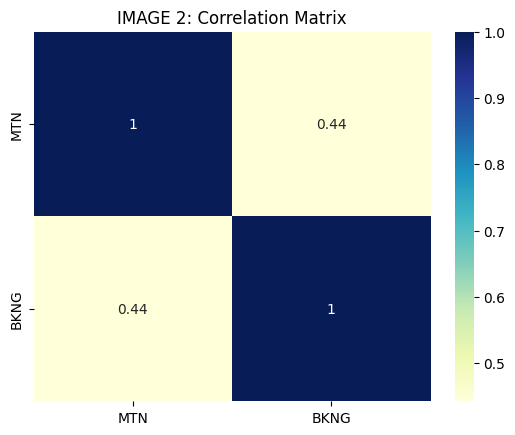

In [ ]:
# Defining the efficient-frontier plotting function
def plot_efficient_frontier(mean_returns, cov_matrix, num_portfolios=10000, risk_free_rate=0.0421):
    weights_arr = np.linspace(0, 1, num=num_portfolios)
    efficient_portfolios = pd.DataFrame(columns=['Return', 'Volatility', 'Sharpe', 'Vail_Weight'])

    for i, weight in enumerate(weights_arr):
        weights = np.array([weight, 1 - weight])
        volatility, return_ = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = (return_ - risk_free_rate) / volatility
        efficient_portfolios.loc[i] = [return_, volatility, sharpe_ratio, weight]

    # Ensure that the dataframe contains valid numerical entries
    if not efficient_portfolios.empty and efficient_portfolios['Sharpe'].notna().all():
        max_sharpe = efficient_portfolios.loc[efficient_portfolios['Sharpe'].idxmax()]
        min_vol = efficient_portfolios.loc[efficient_portfolios['Volatility'].idxmin()]

        # Plotting efficient frontier
        plt.figure(figsize=(10, 7))
        plt.scatter(efficient_portfolios['Volatility'], efficient_portfolios['Return'], c=efficient_portfolios['Sharpe'], cmap='Blues')
        plt.title('IMAGE 1: Efficient Frontier')
        plt.xlabel('Volatility (annualized)')
        plt.ylabel('Return (annualized)')
        plt.colorbar(label='Sharpe Ratio')
        plt.scatter(min_vol['Volatility'], min_vol['Return'], color='silver', marker='1', s=400, label='Min Volatility')
        plt.plot([min_vol['Volatility'],min_vol['Volatility']], [min_vol['Return'],0.192], linestyle=':', color='silver')
        plt.gca().set_ylim([0.192, None])
        minVol = efficient_portfolios.loc[efficient_portfolios['Volatility'].idxmin()]['Volatility']
        plt.text(min_vol['Volatility']+0.001, min_vol['Return']-0.001, f'Volatility = {minVol:.2f}')
        plt.scatter(max_sharpe['Volatility'], max_sharpe['Return'], color='silver', marker='.', s=400, label='Max Sharpe Ratio')
        maxSharpe = efficient_portfolios.loc[efficient_portfolios['Sharpe'].idxmax()]['Sharpe']
        plt.text(max_sharpe['Volatility']+0.001, max_sharpe['Return']-0.0015, f'Sharpe Ratio = {maxSharpe:.2f}')
        plt.legend(labelspacing=1)
        plt.show()
    else:
        print("The efficient frontier could not be plotted due to invalid or missing data.")

    return efficient_portfolios

# Generating and plotting the efficient frontier
efficient_portfolios = plot_efficient_frontier(mean_returns, cov_matrix)

# Checking if portfolios were generated and displaying optimal ones
if not efficient_portfolios.empty:
    print(f"\nPortfolio with Maximum Sharpe Ratio:\n{efficient_portfolios.loc[efficient_portfolios['Sharpe'].idxmax()]}")
    print(f"\nPortfolio with Minimum Volatility:\n{efficient_portfolios.loc[efficient_portfolios['Volatility'].idxmin()]}")
else:
    print("No efficient portfolios were generated.")

# Computing and displaying the correlation between MNT and BKNG
plt.close()
correlation = returns.corr()
heatmap = sns.heatmap(correlation, annot=True, cmap='YlGnBu')
plt.title('IMAGE 2: Correlation Matrix')
plt.savefig('correlation_matrix.png')
print(f"\nCorrelation Matrix:\n{correlation}")

# Analyzing the impact of diversification under perfect correlation
if correlation.iloc[0,1] == 1:
    print("\nDiversification is not useful when Correlation = 1, as both assets move identically.")
else:
    print("\nDiversification reduces idiosyncratic risk, especially when Correlation < 1.\n")

## Individual Stock Analysis

Once computed the portfolio optimization, we look at each stock's Return and compare it to the portfolio's one.

In [ ]:
# Downloading the historical data for both stocks
stocks = ['MTN', 'BKNG']
data = yf.download(stocks, start="2010-01-01", end="2024-04-01")['Adj Close']

# Calculating the daily and annual returns
daily_returns = data.pct_change().dropna()
annual_returns = daily_returns.mean() * 252

# Computing the annual volatility
annual_volatility = daily_returns.std() * np.sqrt(252)

rets = np.log(data/data.shift(1))
# Printing the results
print("\n\nAnnual Returns:")
print(annual_returns)
print("\nAnnual Volatility:")
print(annual_volatility)

[*********************100%%**********************]  2 of 2 completed



Annual Returns:
Ticker
BKNG    0.251525
MTN     0.195998
dtype: float64

Annual Volatility:
Ticker
BKNG    0.333095
MTN     0.313237
dtype: float64


## Stocks-Portfolios Comparison

The stocks’ performances are (as expectable) quite correlated, nevertheless the benefits of diversification are well visible: the portfolios’ Volatility is lower than both individual stocks’ ones. Obviously, this effect comes at the cost of a reduced Return compared to BKNG, which has a higher annual Return with respect to MTN and thus to all the mixed portfolios, clearly counterbalanced by a much higher Volatility, indicating a riskier investment. Therefore, the most appetible risk-adjusted Returns are most probably the max-Sharpe portfolio’s ones, but adding other less correlated stocks would definitely help in reaching a more complete diversification, able to satisfy risk-averse traders.